In [14]:
import requests
import json

## NOTE: These examples won't work because the environments have been disabled in the API
## but you can see the plots in the ./example folder
# task_path = "example/other_example.json"

task_path = r"week_4\snehal_pod\rubal.shakya-enterprise_wiki-3-medium-1753192187\task.json"

with open(task_path, 'r') as file:
    task_json = json.load(file)

API_BASE_URL= "https://tau-bench.turing.com/"

response = requests.post(
    f"{API_BASE_URL}/compute_complexity",
    json=task_json,
    headers={"Content-Type": "application/json"}
)
response.status_code

200

In [15]:
response.json()

{'success': True,
 'plot_base64': 'iVBORw0KGgoAAAANSUhEUgAADRwAAAmzCAIAAABLKeMsAAAABmJLR0QA/wD/AP+gvaeTAAAgAElEQVR4nOzdd5icVaE/8Jntm90U0hsQ0hMMEEIKJBIgBEJvEoxSRIoKVwX5KV7ler0qlouieC3AVXoTQUAIkCgtQgpJKNk0SIVk09tuts+W3x/z3smSzEw2W2Y35PP568x7zrz7nXf2yfOwfj0nXFdXFwIAAAAAAAAAAABCobTWDgAAAAAAAAAAAABthVIdAAAAAAAAAAAABJTqAAAAAAAAAAAAIKBUBwAAAAAAAAAAAAGlOgAAAAAAAAAAAAgo1QEAAAAAAAAAAEBAqQ4AAAAAAAAAAAACSnUAAAAAAAAAAAAQUKoDAAAAAAAAAACAgFIdAAAAAAAAAAAABJTqAAAAAAAAAAAAIKBUBwAAAAAAAAAAAAGlOgAAAAAAAAAAAAgo1QEAAAAAAAAAAEBAqQ4AAAAAAAAAAAACSnUAAAAAAAAAAAAQUKoDAAAAAAAAAACAgFIdAAAAAAAAAAAABJTqAAAAAAAAAAAAIKBUBwAAAAAAAAAAAAGlOgAAAAAAAAAAAAgo1QEAAAAAAAAAAEBAqQ4AAAAAAAAAAAACSnUAAAAAAAAAAAAQUKoDAAAAAAAAAACAgFIdAAAAAAAAAAAABJTqAAAAAAAAAAAAIKBUBwAAAAAAAAAAAAGlOgAAAAAAAAAAAAgo1QEAAAAAAAAAAEBAqQ4AAAAAAAAAAAACSnUAAAAAAAAAAAAQUKoDAAAAAAAAAACAgFIdAAAAAAAAAAAABJTqAAAAAAAAAAAAIKBUBwAAAAAAAAAAAAGlOgAAAAAAAAAAAAgo1QEAAAAAAAAAAEBAqQ4AAAAAAAAAAAACSnUAAAAAAAAAAAAQUKoDAAAAAAAAAACAgFIdAAAAAAAAAAAABJTqAAAAAAAAAAAAIKBUBwAAAAAAA

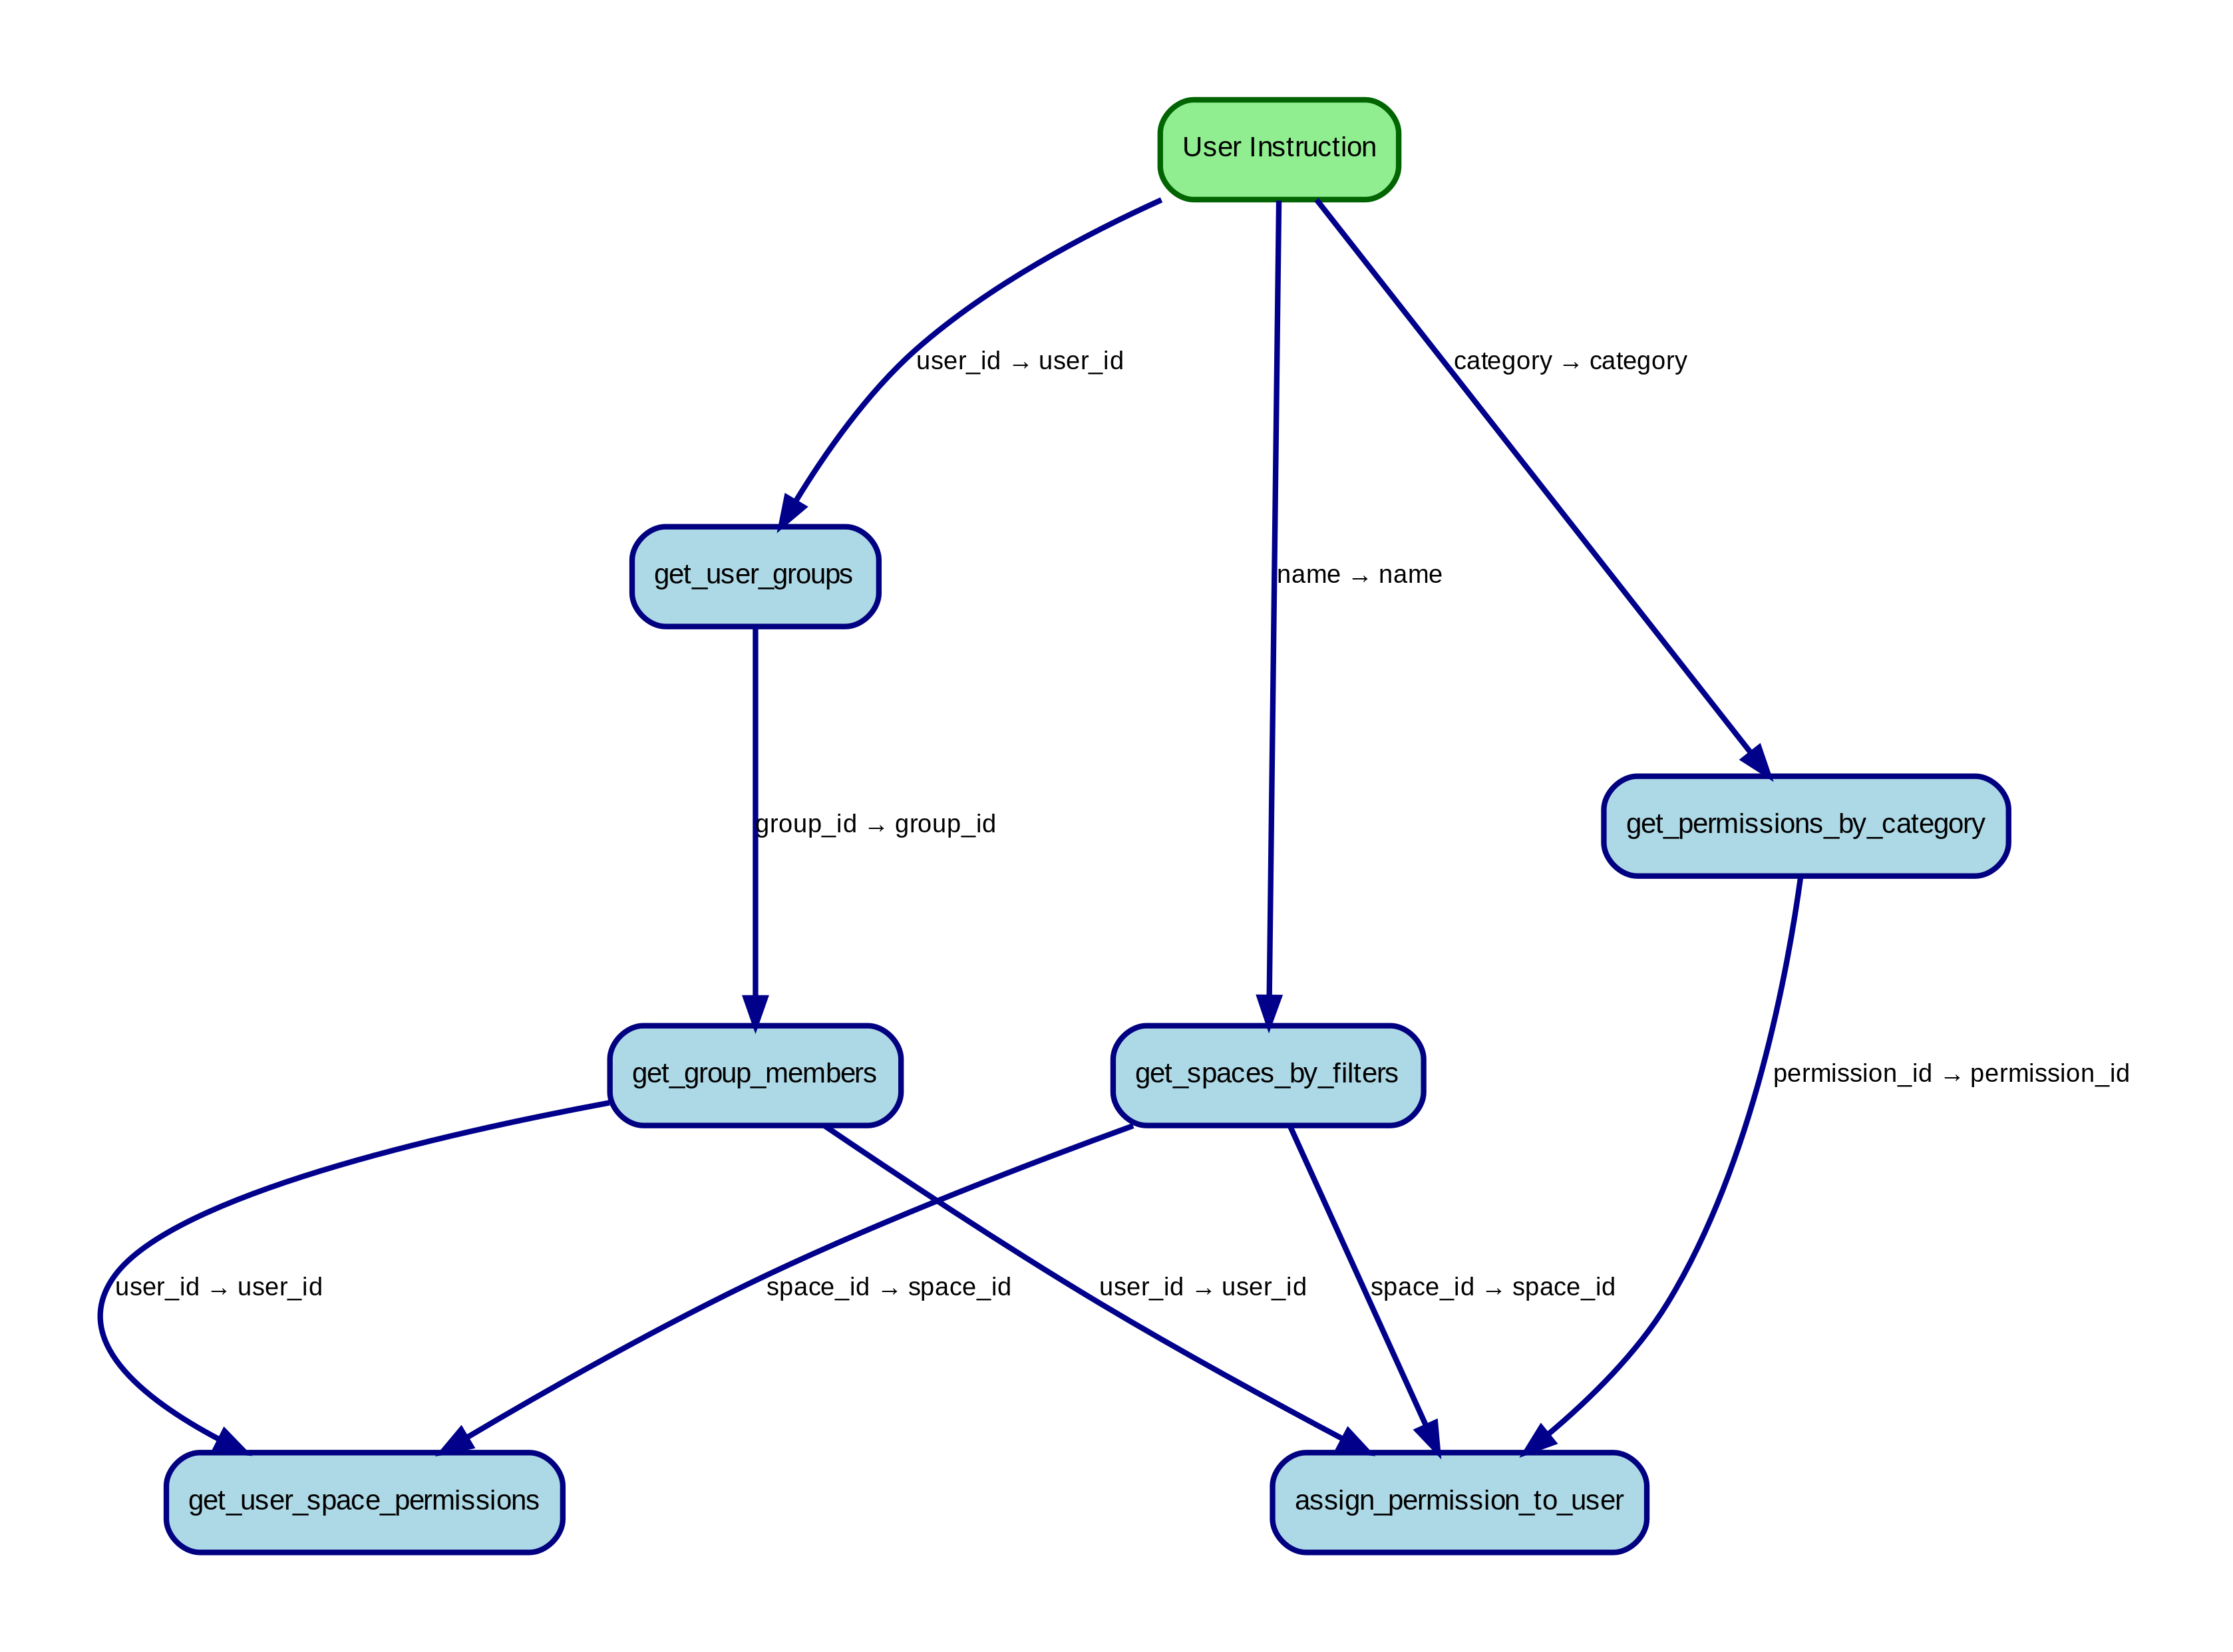

In [18]:
from IPython.display import Image
from IPython.display import display
import base64

plot_base64 = response.json()['plot_base64']
plot_image = base64.b64decode(plot_base64)

display(Image(data=plot_image))